In [14]:
import os
import sys
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
from skimage.segmentation import flood, flood_fill
import dask
from dask.diagnostics import ProgressBar
from dask_jobqueue import PBSCluster

import src
from src import utils
from src.data import loading
from src.attrs import PATHS, GLOBALS

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Full suite
VARIABLES = ['SSH', 'zos', 'SST', 'MLD', 'PSL', 'UBOT', 'VBOT']
START_TIME = datetime.now()

In [77]:
# Get dynamic sea level
zos = loading.load_anomalies('zos', 1251, '011')
north_atlantic = zos.isel(time=0).sel(lat=slice(5, 65), lon=slice(240,360))
north_atlantic_rectangle = xr.where(~np.isnan(north_atlantic).drop_vars('time'), 1, 0)

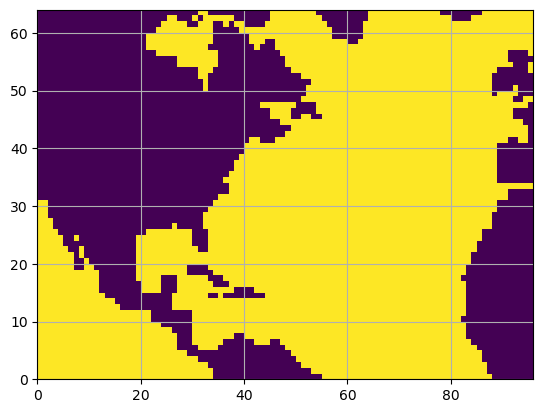

In [78]:
plt.pcolormesh(north_atlantic_rectangle.values)
plt.grid()

In [82]:
# Nice good shape for potential CNN usage
north_atlantic_rectangle.shape

(64, 96)

In [102]:
# Flood fill
stencil = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
north_atlantic_mask = flood_fill(north_atlantic_rectangle.values, (0,0), 2, footprint=stencil)
north_atlantic_mask = np.where(north_atlantic_mask == 2, 0, north_atlantic_mask)

north_atlantic_mask[50:, 0:38] = 0
north_atlantic_mask[0:30, 0:15] = 0

north_atlantic_mask = xr.DataArray(
    north_atlantic_mask, coords=north_atlantic_rectangle.coords
)

In [104]:
north_atlantic_mask

<xarray.DataArray (lat: 64, lon: 96)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])
Coordinates:
  * lat      (lat) float64 5.183 6.126 7.068 8.01 ... 61.73 62.67 63.61 64.55
  * lon      (lon) float64 240.0 241.2 242.5 243.8 ... 355.0 356.2 357.5 358.8

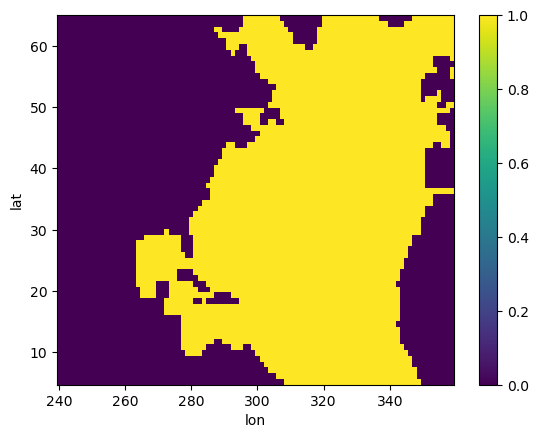

In [103]:
north_atlantic_mask.plot()

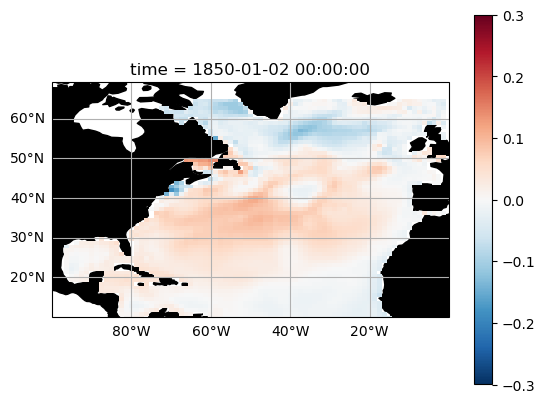

In [105]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
ax.set_extent((-100, 0, 10, 60))
zos_masked = xr.where(
    north_atlantic_mask, 
    zos.sel(**north_atlantic_rectangle.coords).isel(time=0),
    np.nan
)

zos_masked.plot(vmin=-0.3, vmax=0.3, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='k')
gl =  ax.gridlines()
gl.left_labels = True
gl.bottom_labels = True

In [106]:
north_atlantic_mask.name = 'mask'
north_atlantic_mask.attrs['long_name'] = 'north_atlantic_mask'

In [107]:
north_atlantic_mask.to_netcdf(os.path.join(PATHS['grid'], 'north_atlantic_mask.nc'))

In [111]:
north_atlantic_mask = xr.open_dataarray(os.path.join(PATHS['grid'], 'north_atlantic_mask.nc'))

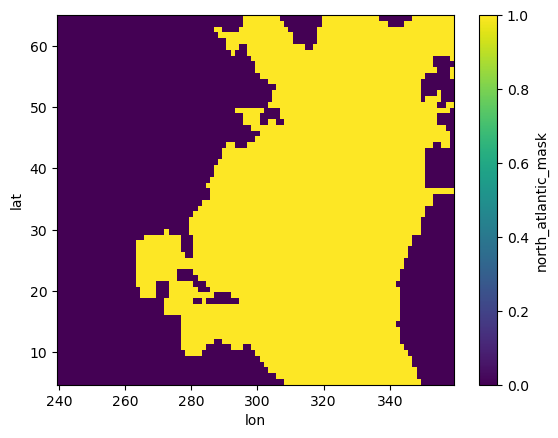

In [112]:
north_atlantic_mask.plot()